# Imports

In [1]:
import os
import numpy as np
import pyro
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm.auto import trange
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST data loading

Data stored in ./data/MNIST

In [2]:
os.makedirs("data", exist_ok=True)

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambd=torch.flatten)
    ]
)

mnist_train = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=False)

Sanity check for the data:

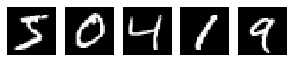

In [4]:
n_examples = 5
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(n_examples, 1))

for i in range(n_examples):
    axes[i].imshow(mnist_train.data[i], cmap="gray")
    axes[i].axis('off')

plt.show()

In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [6]:
mnist_train.data[0].shape

torch.Size([28, 28])

In [7]:
d = 28
D = d ** 2

# RealNVP 

### Manual (from tutorial on representation learning D3S)

In [8]:
class InvertibleTransformation(nn.Module):
    """Single invertible transformation as a building block for our flow model.
    Adapted from https://github.com/gebob19/introduction_to_normalizing_flows/blob/master/normalizing_flows.ipynb
    """
    def __init__(self, input_dim, flip=False):
        assert input_dim % 2 == 0
        super().__init__()
        self.k = input_dim // 2
        self.flip = flip
        self.mu_net = nn.Sequential(nn.Linear(self.k, self.k),
                                   nn.Tanh(),
                                   nn.Linear(self.k, self.k))
        self.sigma_net = nn.Sequential(nn.Linear(self.k, self.k),
                                   nn.Tanh(),
                                   nn.Linear(self.k, self.k))
        

    def forward(self, x):
        x1, x2 = x[:, :self.k], x[:, self.k:]
        
        if self.flip:
            x1, x2 = x2, x1
            
        mu = self.mu_net(x1)
        sigma = self.sigma_net(x1)
        z1 = x1
        z2 = mu + (x2 * torch.exp(sigma))
        
        if self.flip:
            z1, z2 = z2, z1
        
        z = torch.cat([z1, z2], dim=-1)
        log_jacobian = sigma.sum(-1)
                
        return z, log_jacobian
    

    def inverse(self, z):
        z1, z2 = z[:, :self.k], z[:, self.k:]
        
        if self.flip:
            z1, z2 = z2, z1
            
        mu = self.mu_net(z1)
        sigma = self.sigma_net(z1)
        x1 = z1
        x2 = (z2 - mu) * torch.exp(-sigma)
        
        if self.flip:
            x1, x2 = x2, x1
            
        x = torch.cat([x1, x2], dim=-1)
        
        return x

In [9]:
class RealNVPManual(nn.Module):
    """A normalizing flow made of stacked invertible transformations."""
    def __init__(self, input_dim, depth=6, logit_space=False):
        super().__init__()
        self.alpha = 0.1
        self.logit_space = logit_space
        self.latent_dim = input_dim
        self.prior = td.Normal(loc=0., scale=1.)
        self.transformations = nn.ModuleList(
                    [InvertibleTransformation(input_dim=input_dim, flip=(i%2))
                    for i in range(depth)])
        
    def forward(self, x):
        # for MNIST, we model the data in logit space
        if self.logit_space:
            x = x*(1.-self.alpha) + self.alpha*0.5
            x = torch.log(x) - torch.log(1-x)
        
        log_jacobian = 0.
        z = x
        
        for transform in self.transformations:
            z, log_jac = transform(z)
            log_jacobian += log_jac
            
        return z, log_jacobian
    
    def inverse(self, z):
        x = z
        
        for transform in self.transformations[::-1]:
            x = transform.inverse(x)
            
        if self.logit_space:
            x = torch.reciprocal(1 + torch.exp(-x))
            x = (x - (self.alpha*0.5)) / (1-self.alpha)
        
        return x
    
    def log_marginal_likelihood(self, x):
        z, log_jacobian = self.forward(x)
        log_prior = self.prior.log_prob(z)
        return log_prior.sum() + log_jacobian.sum()
    
    def mll_loss(self, x):
        batchsize = x.shape[0]
        mll = - (self.log_marginal_likelihood(x) 
                            / (batchsize * self.latent_dim))
        return mll

In [10]:
flow_model = RealNVPManual(input_dim=D, depth=10, logit_space=True).to(device) 

In [11]:
num_epochs = 20
learning_rate = 1e-5
optimizer = torch.optim.Adam(flow_model.parameters(), lr=learning_rate)
print_interval = 100

In [12]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):
        x_batch = x_batch.to(device)
        flow_model.zero_grad()
        loss = flow_model.mll_loss(x_batch)
        loss.backward()
        optimizer.step()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

In [13]:
def plot_generations(model, num_samples=16):
    """Plot num_samples images generated from the latent space using the model."""
    z_sample = torch.randn(num_samples, model.latent_dim).to(device)
    x_gen = model.inverse(z_sample).cpu().detach().numpy().reshape(-1,28,28)

    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(num_samples, 1))

    for i in range(num_samples):
        axes[i].imshow(x_gen[i], cmap="gray")
        axes[i].axis("off")

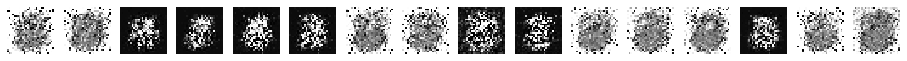

In [14]:
plot_generations(flow_model)

### Pyro

In [15]:
pyro_base_distribution = pyro.distributions.Normal(
    loc=torch.zeros((D,)).to(device),
    scale=torch.ones((D,)).to(device),
)

n_blocks = 10
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_coupling(
            input_dim=D,
            hidden_dims=[32, 32, 32],
        ).to(device)
    )
    blocks.append(
        pyro.distributions.transforms.permute(
            input_dim=D,
            permutation=torch.from_numpy(np.random.permutation(D)).to(device)
        )
    )
    
pyro_transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=pyro_base_distribution,
    transforms=blocks
)

In [16]:
modules = torch.nn.ModuleList([b for i, b in enumerate(blocks) if i%2 == 0])
num_epochs = 10
learning_rate = 1e-5
optimizer = torch.optim.Adam(modules.parameters(), lr=learning_rate)
print_interval = 100

In [17]:
pbar = trange(num_epochs)
for epoch in pbar:
    for i, (x_batch, _) in enumerate(trainloader):        
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        loss = - pyro_transformed_distribution.log_prob(x_batch).mean()
        loss.backward()
        optimizer.step()

        pyro_transformed_distribution.clear_cache()
        
        if i % print_interval == 0:
            pbar.set_postfix_str(f"loss = {loss.item():.3f}")

## Generated examples

In [18]:
n_examples = 10
generated_images = (
    pyro_transformed_distribution
    .sample((n_examples,))
    .detach()
    .view((n_examples, d, d))
    .to("cpu")
    .numpy()
)

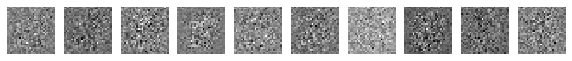

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(n_examples, 1))

for i in range(n_examples):
    axes[i].imshow(generated_images[i], cmap="gray")
    axes[i].axis('off')
    
plt.show()